In [11]:
import numpy as np
import pandas as pd
import sys
import matplotlib
import matplotlib.animation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json
import pyaudio
import os
from pynput.keyboard import Key, Listener
import threading

In [2]:
#プロット
def pltplot(data):
    #print(len(data))
    #data = data[0:1000]
    plt.figure()
    x = range(len(data))
    plt.plot(x, data)
    plt.show()

In [3]:
#オーディオ鳴らす
def play_tone(stream, data, frequency=440, length=1, rate=44100):
    chunks = []
    chunks.append(sines(data, rate))
    chunk = np.concatenate(chunks) * 0.1
    #pltplot(chunk)
    stream.write(chunk.astype(np.float32).tostring())

In [4]:
#指定周波数でサイン波を生成する
def sine(frequency, length, rate):
    length = int(length * rate)
    factor = float(frequency) * (np.pi * 2) / rate
    return np.sin(np.arange(length) * factor)

In [5]:
#連続サイン波を生成する
def sines(data, rate):
    freqs = []
    for adata in data:
        tmp = np.ones(1000)
        freqs.append((600+adata*10) * tmp)
    freqs = np.concatenate(freqs)
    phazes_diff = 2 * np.pi * freqs / rate
    phazes = np.cumsum(phazes_diff)
    return np.sin(phazes)

In [57]:
#視覚情報を聴覚情報に
class eye_to_ear:
    def __init__(self, mapname):
        try:
            f = open(mapname, 'r')
            self.mapdata = json.load(f)
        except:
            print("error: wrong mapname")
            sys.exit()
        f.close()
        return
    
    def show_map(self):
        print(self.mapdata)
        return
    
    def is_collision(self, pos):
        return self.in_objects(pos) or self.is_outside(pos)
        
    def in_objects(self, pos):
        obj = self.mapdata['objects']
        for i in obj:
            count = 0
            if (pos[0] > obj[i]['x'][0]) & (pos[0] < obj[i]['x'][1]): count += 1
            if (pos[1] > obj[i]['y'][0]) & (pos[1] < obj[i]['y'][1]): count += 1
            if (pos[2] > obj[i]['z'][0]) & (pos[2] < obj[i]['z'][1]): count += 1
            if count == 3: return True
        return False
    
    def is_outside(self, pos):
        if (pos[0] > self.mapdata['mapsize']['x_max']) | (pos[0] < 0): return True
        if (pos[1] > self.mapdata['mapsize']['y_max']) | (pos[1] < 0): return True
        if (pos[2] > self.mapdata['mapsize']['z_max']) | (pos[2] < 0): return True
        return False
    
    def create_map3d(self, reso=0.5):
        x_3d = []
        y_3d = []
        z_3d = []
        for x in np.arange(0,self.mapdata['mapsize']['x_max'],reso):
            for y in np.arange(0,self.mapdata['mapsize']['y_max'],reso):
                for z in np.arange(0,self.mapdata['mapsize']['z_max'],reso):
                    if self.in_objects([x, y, z]):
                        x_3d.append(x)
                        y_3d.append(y)
                        z_3d.append(z)
        self.map3d = [x_3d, y_3d, z_3d]
        
    def plot_map3d(self, size=500):
        fig = plt.figure()
        ax = fig.add_subplot(111,projection='3d')
        ax.scatter(self.map3d[0],self.map3d[1],self.map3d[2], marker='s',s=size)
        ax.scatter(self.pos[0], self.pos[1], self.pos[2], marker='^', s=500, c='red')
        ax.set_xlim(0,self.mapdata['mapsize']['x_max'])
        ax.set_ylim(0,self.mapdata['mapsize']['y_max'])
        ax.set_zlim(0,self.mapdata['mapsize']['z_max'])
        plt.show()
    
    def calc_height(self):
        pos = self.pos.copy()
        obj = self.mapdata['objects']
        while(self.in_objects(pos) == False):
            pos[2] -= 0.01
            if pos[2] < 0:
                return (self.pos[2])
        return self.pos[2] - pos[2]
    
    def set_pos(self, x, y, z):
        pos = np.array([x, y, z], dtype="float64")
        if self.is_collision(pos):
            print("error: wrong position")
            return
        self.pos = pos
        print("now_pos =", self.pos)
        return
    
    def get_pos(self):
        return self.pos

    def set_deg(self, deg):
        if deg < 0 or 360 <= deg:
            print("error: angle must be [0,360)")
            return
        self.deg = deg
        
    def set_ele(self, ele):
        if ele < 0 or 180 <= ele:
            print("error: elevation must be [0,180)")
            return
        self.ele = ele
    
    def set_angle(self, deg, ele):
        self.set_deg(deg)
        self.set_ele(ele)
        print("deg, ele =", deg, ele)
    
    def get_deg(self):
        return self.deg
    
    def get_ele(self):
        return self.ele
        
    def scan(self, deg, ele_max=120, ele_min=30, ele_step=1):
        if deg < 0 or 360 <= deg:
            print("error: angle must be [0,360)")
            return
        print("now_angle =", deg)

        disdata = []
        try:
            pos = self.pos.copy()
            acc = np.array([np.sin(np.pi*deg/180), -1*np.cos(np.pi*deg/180)])
        except ValueError:
            print("error: position or angle is not defined")
            return

        for ele in range(ele_min, ele_max, ele_step):
            pos_3d = pos.copy()
            acc_3d = acc * np.sin(np.pi*ele/180)
            acc_3d = np.append(acc_3d, -1*np.cos(np.pi*ele/180)) * 0.1
            #print(acc_3d, np.linalg.norm(acc_3d))
            
            dis = 0
            while(self.is_collision(pos_3d) == False):
                dis += 0.1
                pos_3d += acc_3d
            #print(ele, pos_3d)
            disdata.append(dis)
        
        #pltplot(disdata)
        return disdata
    
    #90度回転させながらscan_mapに格納
    def rotateData(self, scan_map, scandata, d):
        for i, data in enumerate(scandata):
            coo_x = int(i * np.cos(np.pi*d/180))
            coo_y = int(i * np.sin(np.pi*d/180))
            if scan_map[coo_x, coo_y] == 0:
                scan_map[coo_x, coo_y] = data
            else:
                scan_map[coo_x, coo_y] = (scan_map[coo_x, coo_y] + data) / 2

    def scan90(self, deg):
        scan_map = np.zeros([90,90])
        for d in range(90):
            scandata = self.scan(deg+d, 120, 30)
            scan_map[d] = np.array(scandata)
            #self.rotateData(scan_map, scandata, d)
        return scan_map
    
    def scan_square(self, size=45, step=3):
        reso = int(size/step)
        scan_map = np.zeros([reso,reso])
        ele_min = self.ele - int(size / 2)
        ele_max = ele_min + size
        for d in range(reso):
            scandata = self.scan(self.deg+(d-int(reso/2))*step, ele_max=ele_max, ele_min=ele_min, ele_step=step)
            scan_map[d] = np.array(scandata)
        return scan_map.T[::-1,:]

In [7]:
#キー入力時の動作
def on_press(key):
    print("pressed")
    try:
        if key.char == "w" : ka.moveUp()
        if key.char == "a" : ka.moveLeft()
        if key.char == "s" : ka.moveDown()
        if key.char == "d" : ka.moveRight()
    except AttributeError:
        if key == Key.up: ka.lookUp()
        if key == Key.down: ka.lookDown()
        if key == Key.left: ka.lookLeft()
        if key == Key.right: ka.lookRight()
        if key == Key.esc:
            print('キー受け付けを終了しました')
            return False
        
def on_release(key):
    pass

In [8]:
class key_animation:
    def __init__(self, ete):
        self.ete = ete
        self.data = ete.scan_square()
        self.fig = plt.figure()
        self.ax = plt.axes()
        self.ani = matplotlib.animation.FuncAnimation(self.fig, self.updatefig, interval=500)
    def updatefig(self, i):
        plt.clf()
        #self.figdata = self.data[self.pos[0]:self.pos[0]+self.imsize, self.pos[1]:self.pos[1]+self.imsize]
        self.figdata = ete.scan_square()
        plt.imshow(self.figdata, cmap="binary")
        plt.clim(vmin=0, vmax=20)
        plt.colorbar()
    def moveUp(self):
        pos = self.ete.get_pos() + np.array([0, 10, 0])
        if not self.ete.is_collision(pos):
            self.ete.set_pos(pos[0], pos[1], pos[2])
    def moveDown(self):
        pos = self.ete.get_pos() + np.array([0, -10, 0])
        if not self.ete.is_collision(pos):
            self.ete.set_pos(pos[0], pos[1], pos[2])
    def moveLeft(self):
        pos = self.ete.get_pos() + np.array([-10, 0, 0])
        if not self.ete.is_collision(pos):
            self.ete.set_pos(pos[0], pos[1], pos[2])
    def moveRight(self):
        pos = self.ete.get_pos() + np.array([10, 0, 0])
        if not self.ete.is_collision(pos):
            self.ete.set_pos(pos[0], pos[1], pos[2])
    def lookUp(self):
        self.ete.set_ele(self.ete.get_ele()+10)
    def lookDown(self):
        self.ete.set_ele(self.ete.get_ele()-10)
    def lookRight(self):
        self.ete.set_deg(self.ete.get_deg()+30)
    def lookLeft(self):
        self.ete.set_deg(self.ete.get_deg()-30)
    def animate(self):
        plt.show()
        return self

now_pos = [ 5. 50.  2.]
deg, ele = 90 90
now_angle = 69
now_angle = 72
now_angle = 75
now_angle = 78
now_angle = 81
now_angle = 84
now_angle = 87
now_angle = 90
now_angle = 93
now_angle = 96
now_angle = 99
now_angle = 102
now_angle = 105
now_angle = 108
now_angle = 111


<IPython.core.display.Javascript object>


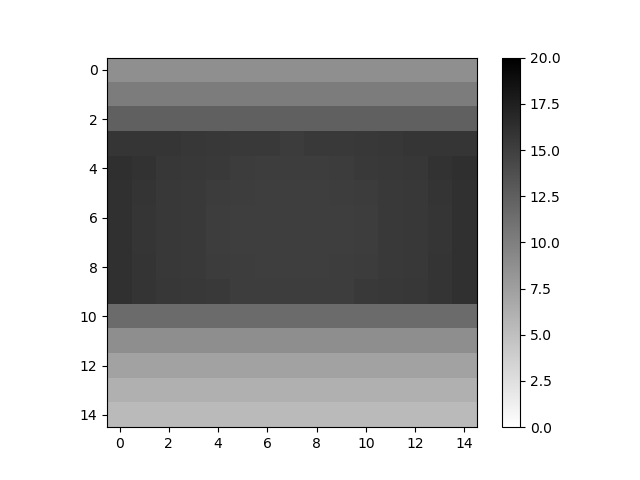

In [14]:
%matplotlib nbagg
# キー入力でグラフを変化させる

ete = eye_to_ear("station_platform.json")
ete.set_pos(5,50,2)
ete.set_angle(90,90)
ete.calc_height()
#scandata = ete.scan_square()

ka = key_animation(ete)
ka.animate()

def key_listener():
    try:
        with Listener(on_press=on_press, on_release=on_release) as listener:
            listener.join()
    except:
        pass

key_thread = threading.Thread(target=key_listener)
key_thread.start()

In [ ]:
# 90度スキャンする
ete = eye_to_ear("station_platform.json")
ete.set_pos(5,50,2)
ete.set_angle(90,90)
ete.calc_height()
scandata = ete.scan90(90)

now_pos = [ 5. 50.  2.]
now_angle = 90


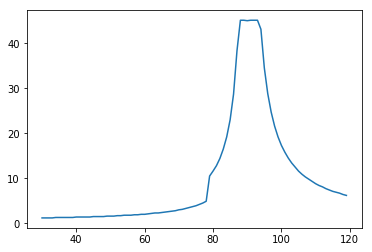

In [10]:
# スキャンし，音を鳴らす
ete = eye_to_ear("station_platform.json")
ete.set_pos(5,50,2)
data = ete.scan(90)
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paFloat32, channels=1, rate=44100, output=1)
play_tone(stream, data)
stream.close()
p.terminate()

<IPython.core.display.Javascript object>


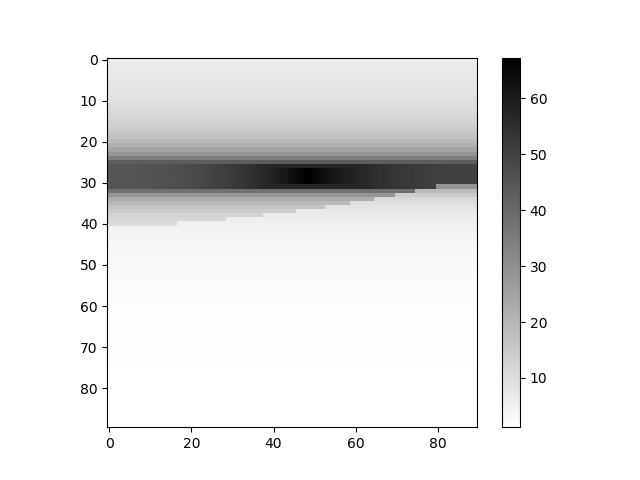

[[1.2 1.2 1.2 ... 1.2 1.2 1.2]
 [1.2 1.2 1.2 ... 1.2 1.2 1.2]
 [1.2 1.2 1.2 ... 1.2 1.2 1.2]
 ...
 [6.7 6.7 6.7 ... 6.7 6.7 6.7]
 [6.4 6.4 6.4 ... 6.4 6.4 6.4]
 [6.2 6.2 6.2 ... 6.2 6.2 6.2]]


In [94]:
#xx, yy = np.meshgrid(range(30,120), range(30,120))
plt.figure()
#plt.pcolormesh(xx, yy, scandata.T, cmap='binary')
plt.imshow(scandata.T[::-1,:], cmap='binary')
pp=plt.colorbar (orientation="vertical")
plt.show()
print(scandata.T)

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


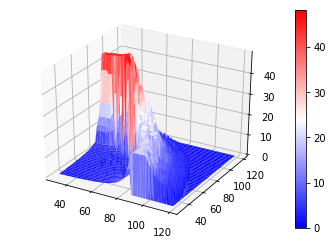

In [91]:
fig = plt.figure()
xx, yy = np.meshgrid(range(30,120), range(30,120))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xx, yy, scandata, cmap='bwr', linewidth=1)
fig.colorbar(surf)
fig.show()

{'mapsize': {'x_max': 50, 'y_max': 100, 'z_max': 5}, 'objects': {'platform': {'x': [0, 10], 'y': [0, 100], 'z': [0, 1]}}}
now_pos = [ 5. 50.  2.]


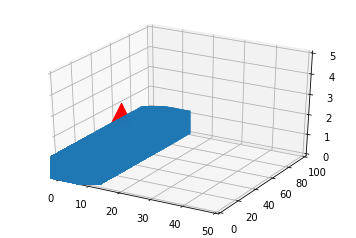

In [45]:
ete = eye_to_ear("station_platform.json")
ete.show_map()
ete.create_map3d(0.5)
ete.set_pos(5,50,2)
ete.plot_map3d()

{'mapsize': {'x_max': 25, 'y_max': 50, 'z_max': 3}, 'objects': {'locker': {'x': [0, 3], 'y': [48, 50], 'z': [0, 2]}, 'table1': {'x': [5, 14], 'y': [46, 50], 'z': [0, 0.25]}, 'tv': {'x': [6, 13], 'y': [49, 49], 'z': [0.25, 0.5]}, 'table2': {'x': [9, 15], 'y': [20, 50], 'z': [0, 0.25]}, 'printer': {'x': [4, 10], 'y': [6, 10], 'z': [0, 0.75]}, 'table3': {'x': [11, 20], 'y': [6, 10], 'z': [0, 0.5]}}}
now_pos = [ 5. 25.  0.]


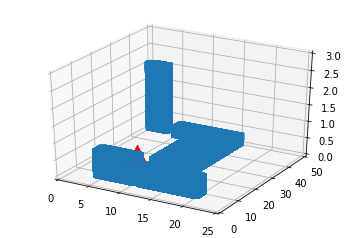

In [58]:
ete = eye_to_ear("room2.json")
ete.show_map()
ete.create_map3d(0.05)
ete.set_pos(5,25,0)
ete.plot_map3d(50)

In [54]:
f = open("room2.json", 'r')
#print(f.read())
mapdata = json.load(f)